In [1]:
import numpy as np
import netCDF4
import platform
import re
import sys
import importlib
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import os
import glob
import rasterio
from PIL import Image
import pymannkendall as mk
import seaborn as sns
from joblib import Parallel, delayed

if platform.system() == 'Darwin':
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive/'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = '/home/subin/data'
    cpuserver_data_FP = '/home/subin/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, cpuserver_data_FP)

import HydroAI.Plot as hPlot
import HydroAI.LULC as hLULC
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
importlib.reload(hLULC);
importlib.reload(hPlot);
importlib.reload(hData);
importlib.reload(hGrid);

import warnings
warnings.filterwarnings("ignore")

/home/subin/data /home/subin/cpuserver_data


## 0. Read and plot MODIS raw dataset



In [2]:
FP = cpuserver_data_FP + '/MODIS/MOD13A2/' # vegetation_indices (NDVI)
FP = cpuserver_data_FP + '/MODIS/MOD11A2/' # LST

file_list =  hData.get_file_list(FP, 'hdf')
print(file_list[:5])
input_file = file_list[4]

['/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h19v07.061.2021154175517.hdf', '/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h19v08.061.2021154174227.hdf', '/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h19v09.061.2021154174220.hdf', '/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h20v07.061.2021154175727.hdf', '/home/subin/cpuserver_data/MODIS/MOD11A2/2010.01.01/MOD11A2.A2010001.h20v08.061.2021154175736.hdf']


In [44]:
hdf = SD(input_file, SDC.READ)
datasets = hdf.datasets()
for name, info in datasets.items():
    print(name)
    print(info)

LST_Day_1km
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 23, 0)
QC_Day
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 1)
Day_view_time
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 2)
Day_view_angl
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 3)
LST_Night_1km
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 23, 4)
QC_Night
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 5)
Night_view_time
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 6)
Night_view_angl
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 7)
Emis_31
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 8)
Emis_32
(('YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), (1200, 1200), 21, 9)
Cl

Failed to read '1 km 16 days NDVI' from HDF4 file /home/subin/cpuserver_data/MODIS/lst/MOD11A2.A2010001.h20v08.061.2021154175736.hdf: select: non-existent dataset
<class 'numpy.ndarray'>
(1200, 1200)


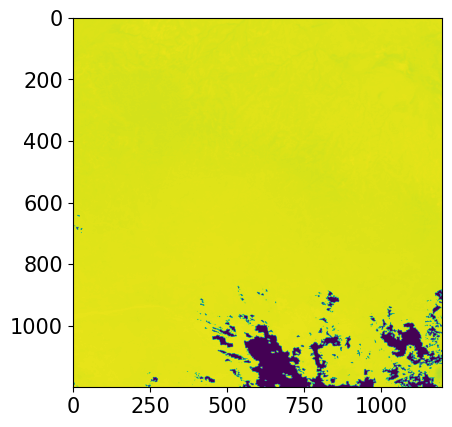

In [45]:
var = hData.read_hdf4_variable(input_file, '1 km 16 days NDVI')
var = hData.read_hdf4_variable(input_file, 'LST_Night_1km')
print(type(var))
print(np.shape(var))
plt.imshow(var)

## 1. Read merged tif image dataset (NDVI, LST) with cropping study area

In [14]:
bound=[-20, 55, -35, 40] # Study area = entire Africa (lon, lat)
study_month=5

In [15]:
def find_study_dates(root_folder, regex_date='[0-9][0-9][0-9][0-9].[0-9][0-9].[0-9][0-9]'):
    dates = []
    folder_pattern = os.path.join(root_folder, regex_date)
    folders = glob.glob(folder_pattern)
    folders = sorted(folders)
    for folder in folders:
        date_pattern = r'\d{4}\.\d{2}\.\d{2}'
        match = re.search(date_pattern, folder).group(0)
        dates.append(match) 
    return dates

In [16]:
def read_tif_images(root_folder, variable, matched_dates=[], bound=bound):
    images = []; dates = []

    if matched_dates == []:
        folder_pattern = os.path.join(root_folder, '[0-9][0-9][0-9][0-9].[0-9][0-9].[0-9][0-9]')
        folders = glob.glob(folder_pattern)
        folders = sorted(folders)
    else:    
        folders = [f'{root_folder}/{md}' for md in matched_dates]

    #for fi, folder in enumerate(folders[:5]): # Light version for test code
    for fi, folder in enumerate(folders):

        merged_tif_file = glob.glob(os.path.join(folder, f'merged/*{variable}_WGS84.tif'))

        try:
            with rasterio.open(merged_tif_file[0]) as src:
                if fi == 0:
                    transform = src.transform
                    width = src.width
                    height = src.height
                    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
                    xs, ys = rasterio.transform.xy(transform, rows, cols)
                    lons = np.array(xs)
                    lats = np.array(ys)
                    
                    # Crop study_area
                    lon_crop = (lons > bound[0]) & (lons < bound[1])
                    lat_crop = (lats > bound[2]) & (lats < bound[3])
    
                    combined_crop = lat_crop & lon_crop
                    
                    # Find the bounding box of the true values in the mask
                    row_indices, col_indices = np.where(combined_crop)
                    min_row, max_row = row_indices.min(), row_indices.max()
                    min_col, max_col = col_indices.min(), col_indices.max()
                    
                    cropped_lat = lats[min_row:max_row+1, min_col:max_col+1]
                    cropped_lon = lons[min_row:max_row+1, min_col:max_col+1]
                    
                data = src.read(1).astype('float32')
                cropped_data = data[min_row:max_row+1, min_col:max_col+1]
                images.append( cropped_data )
                if np.shape(cropped_data) != (8304, 8304):
                    print(folder, np.shape(cropped_data))
        except IndexError:
            print(f'No dataset in \n {folder}')
            nan_data = np.full( ( max_row+1 - min_row , max_col+1 - min_col ), np.nan )
            images.append( nan_data )

        date_pattern = r'\d{4}\.\d{2}\.\d{2}'
        match = re.search(date_pattern, folder).group(0)
        dates.append(match)
    
    images = np.transpose(images, (1, 2, 0)) # Transforming shape into (lat(row), lon(column), date)
    return images, cropped_lon, cropped_lat, dates

In [17]:
study_dates = find_study_dates(f'{cpuserver_data_FP}/MODIS/MOD13A2', 
                               regex_date=f'[0-9][0-9][0-9][0-9].[0-9][{study_month}].[0-9][0-9]')

# Due to the different shape between (2000 ~ 2023) and 2024, split study_dates 
pattern_without_2024 = r"^(?!2024\.)\d{4}\.(0[3-5])\.\d{2}$"
study_dates_without_2024 = [x for x in study_dates if re.match(pattern_without_2024, x)]
print(study_dates_without_2024[-5:])

pattern_with_2024 = r"^2024\.(0[3-5])\.\d{2}$"
study_dates_with_2024 = [x for x in study_dates if re.match(pattern_with_2024, x)]
print(study_dates_with_2024)

['2021.05.25', '2022.05.09', '2022.05.25', '2023.05.09', '2023.05.25']
['2024.05.08']


/home/subin/cpuserver_data/MODIS/MOD13A2/2024.05.08 (7205, 7205)
[ 39.99479561  39.98438683  39.97397805 ... -34.9692176  -34.97962638
 -34.99003516] [-19.99298919 -19.98258042 -19.97217164 ...  54.97102402  54.9814328
  54.99184157]
(7205, 7205, 1) (1,)


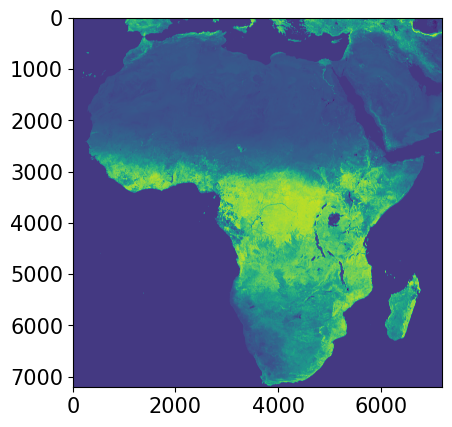

In [18]:
NDVI_images, NDVI_lon, NDVI_lat, NDVI_dates = read_tif_images(f'{cpuserver_data_FP}/MODIS/MOD13A2', 'NDVI', matched_dates=study_dates_with_2024)

print(NDVI_lat[:, 0], NDVI_lon[0])
print(np.shape(NDVI_images), np.shape(NDVI_dates))
plt.imshow(NDVI_images[:, :, 0])

/home/subin/cpuserver_data/MODIS/MOD11A2/2024.05.08 (7205, 7205)
[ 39.99479561  39.98438683  39.97397806 ... -34.96921761 -34.97962639
 -34.99003517] [-19.9929892  -19.98258042 -19.97217164 ...  54.97102403  54.9814328
  54.99184158]
(7205, 7205, 1) (1,)


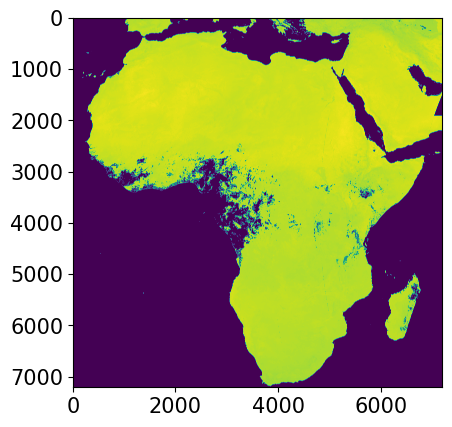

In [19]:
# LST 8 days (twice than NDVI) -> matched_dates are needed.
LST_images, LST_lon, LST_lat, LST_dates = read_tif_images(f'{cpuserver_data_FP}/MODIS/MOD11A2', 'LST', matched_dates=study_dates_with_2024)

print(LST_lat[:, 0], LST_lon[0])
print(np.shape(LST_images), np.shape(LST_dates))
plt.imshow(LST_images[:, :, 0])

## 2. Mask non-valid values and apply scale factors 
(ref. raw dataset nc file)

In [20]:
# valid range (-2000, 10000)
NDVI_images[(NDVI_images < -2000) & (NDVI_images > 10000)] = np.nan

# valid range (7500, -1)
LST_images[LST_images < 7500] = np.nan

In [21]:
# 1_km_16_days_NDVI
NDVI_scale_factor = 10000.0; NDVI_add_offset = 0.0
NDVI_images_scaled = NDVI_images / NDVI_scale_factor + NDVI_add_offset
#print(NDVI_images_scaled[1000:1500, 1000:1500, 0])
NDVI_images = [] # Flush memory

# LST_Day_1km 
LST_scale_factor = 0.02; LST_add_offset = 0.0
LST_images_scaled = LST_images * LST_scale_factor + LST_add_offset
#print(LST_images_scaled[1000:1500, 1000:1500, 0])
LST_images = [] # Flush memory

## 3. Apply Resampling and save resampled nc files
(for standardized grid system)

In [22]:
target_projection = 'eqd_001' 
domain_lon, domain_lat = hGrid.generate_lon_lat_eqdgrid(0.01)
print(np.shape(domain_lon))

lat_0 = 90
lon_0 = 180

domain_lon = domain_lon[100*(lat_0-bound[3]):100*(lat_0-bound[2]), 100*(lon_0+bound[0]):100*(lon_0+bound[1])]
domain_lat = domain_lat[100*(lat_0-bound[3]):100*(lat_0-bound[2]), 100*(lon_0+bound[0]):100*(lon_0+bound[1])]
print(np.shape(domain_lon))
print(domain_lat[:,0])
print(domain_lon[0])

(18000, 36000)
(7500, 7500)
[ 39.995  39.985  39.975 ... -34.975 -34.985 -34.995]
[-19.995 -19.985 -19.975 ...  54.975  54.985  54.995]


In [23]:
m, n = np.shape(domain_lon)
NDVI_total = np.zeros((m, n, len(NDVI_dates)), dtype='float64')
LST_total  = np.zeros((m, n, len(LST_dates)),  dtype='float64')

for i, date in enumerate(NDVI_dates):
    Resampled_NDVI  = hData.Resampling(domain_lon, domain_lat, NDVI_lon, NDVI_lat, NDVI_images_scaled[:, :, i], 
                                       sampling_method='nearest', mag_factor=3)
    Resampled_LST   = hData.Resampling(domain_lon, domain_lat, LST_lon,  LST_lat,  LST_images_scaled[:, :, i],  
                                       sampling_method='nearest', mag_factor=3)

    NDVI_total[:, :, i] = Resampled_NDVI
    LST_total[:, :, i]  = Resampled_LST


#nc_file_name = f'{cpuserver_data_FP}/MODIS/MODIS_NDVI_LST_dates{len(NDVI_dates)}_R_eqd001.nc'
nc_file_name = f'/home/subin/MODIS_NDVI_LST_month{study_month}_2024_R_eqd001.nc'

print(f"Saving: {nc_file_name}")
hData.create_netcdf_file(
    nc_file    = nc_file_name,
    latitude   = domain_lat,
    longitude  = domain_lon,
    NDVI  = NDVI_total,
    LST   = LST_total)

print(f"NetCDF file created: {nc_file_name}")

Saving: /home/subin/MODIS_NDVI_LST_month5_dates49_R_eqd001.nc
NetCDF file /home/subin/MODIS_NDVI_LST_month5_dates49_R_eqd001.nc created successfully.
NetCDF file created: /home/subin/MODIS_NDVI_LST_month5_dates49_R_eqd001.nc


In [24]:
# Flush memories
NDVI_images_scaled = []
LST_images_scaled = []

len(NDVI_dates)

1

### +@) Calculate anomaly

In [32]:
study_month_list = [3, 4, 5]
m, n = np.shape(domain_lon)
NDVI_anomaly = np.zeros((m, n, len(study_month_list)), dtype='float64')
LST_anomaly = np.zeros((m, n, len(study_month_list)), dtype='float64')
VHI_anomaly = np.zeros((m, n, len(study_month_list)), dtype='float64')

alpha=0.5

for i, month in enumerate(study_month_list):
    nc_file_name = f'{cpuserver_data_FP}/MODIS/JW_project/MODIS_NDVI_LST_month{month}_2024_R_eqd001.nc'
    
    nc_data  = netCDF4.Dataset(nc_file_name)
    NDVI_total  = nc_data.variables['NDVI'][:].data
    LST_total  = nc_data.variables['LST'][:].data
    domain_lon = nc_data.variables['longitude'][:].data
    domain_lat = nc_data.variables['latitude'][:].data
    nc_data.close()

    NDVI_2024 = np.nanmean(NDVI_total, axis=2)
    LST_2024 = np.nanmean(LST_total, axis=2)
    
    previous_NDVI = np.load(f'{cpuserver_data_FP}/MODIS/JW_project/MODIS_NDVI_month{month}_2024_R_eqd001.npy')
    previous_LST  = np.load(f'{cpuserver_data_FP}/MODIS/JW_project/MODIS_LST_month{month}_2024_R_eqd001.npy')

    print(np.shape(NDVI_2024), np.shape(previous_NDVI))
    N_ano = NDVI_2024 - previous_NDVI
    L_ano = LST_2024 - previous_LST
    
    one_VCI = ( N_ano - np.nanmax(N_ano) ) / ( np.nanmax(N_ano) - np.nanmin(N_ano) )
    one_TCI = ( np.nanmax(L_ano) - L_ano ) / ( np.nanmax(L_ano) - np.nanmin(L_ano) )
    V_ano = alpha*one_VCI + (1-alpha)*one_TCI
    
    NDVI_anomaly[:, :, i] = N_ano
    LST_anomaly[:, :, i] = L_ano
    VHI_anomaly[:, :, i] = V_ano

(7500, 7500) (7500, 7500)
(7500, 7500) (7500, 7500)
(7500, 7500) (7500, 7500)


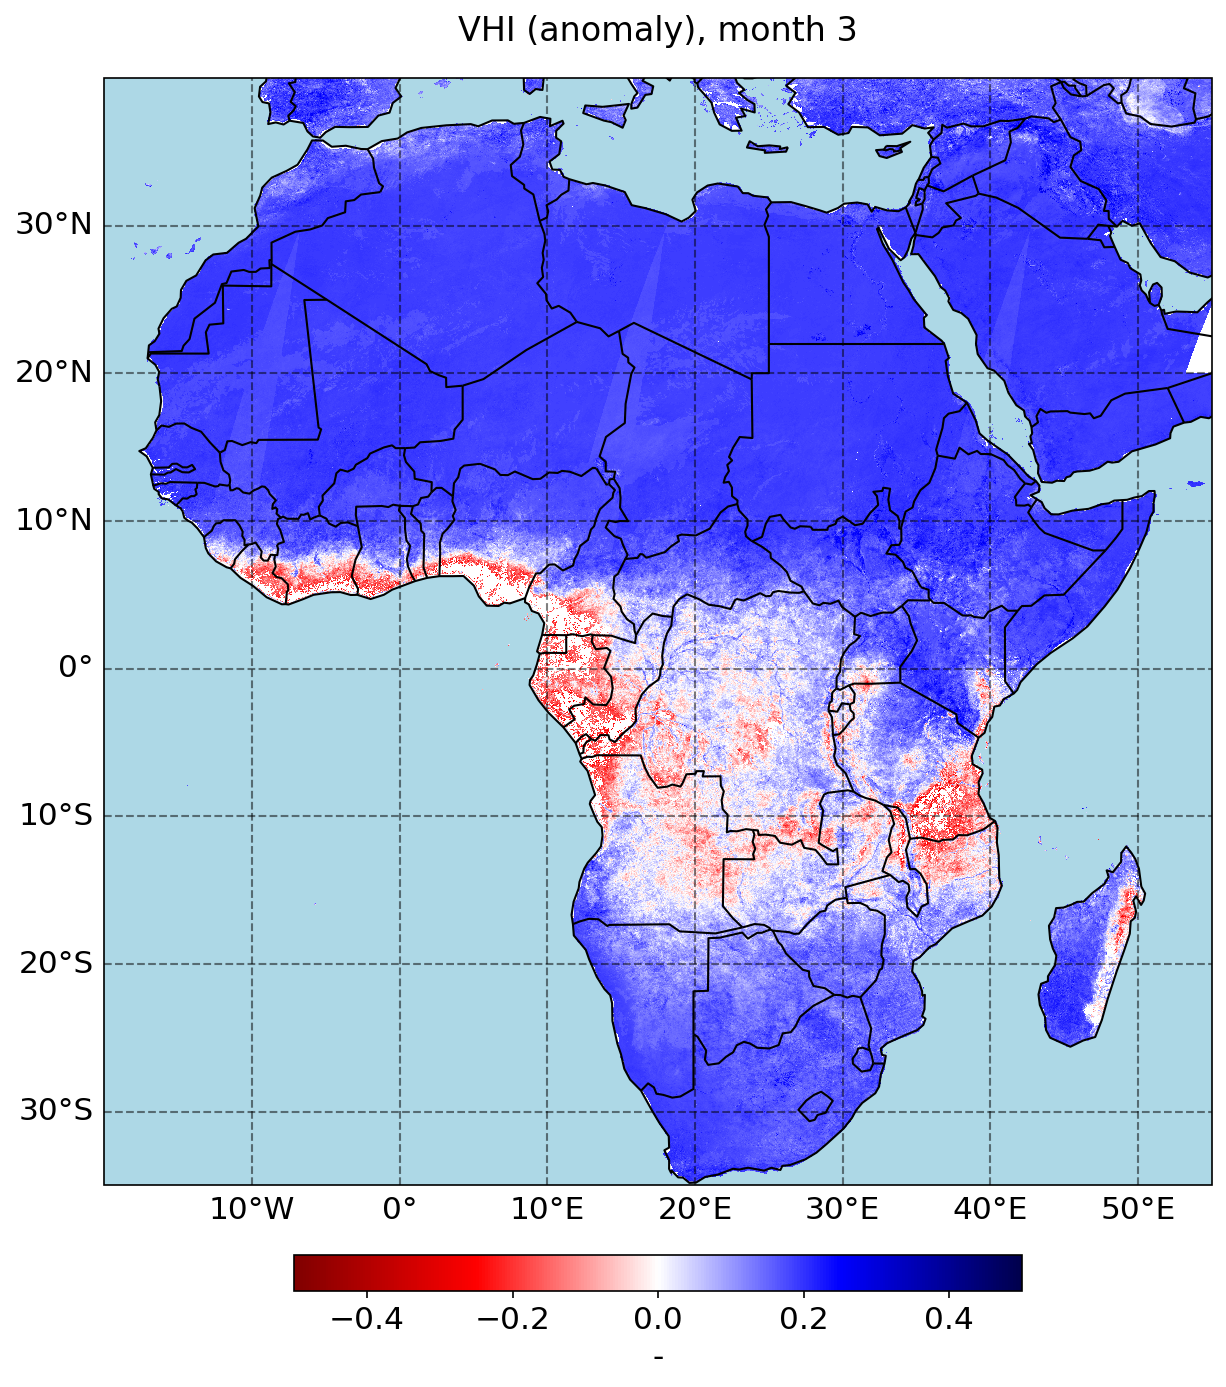

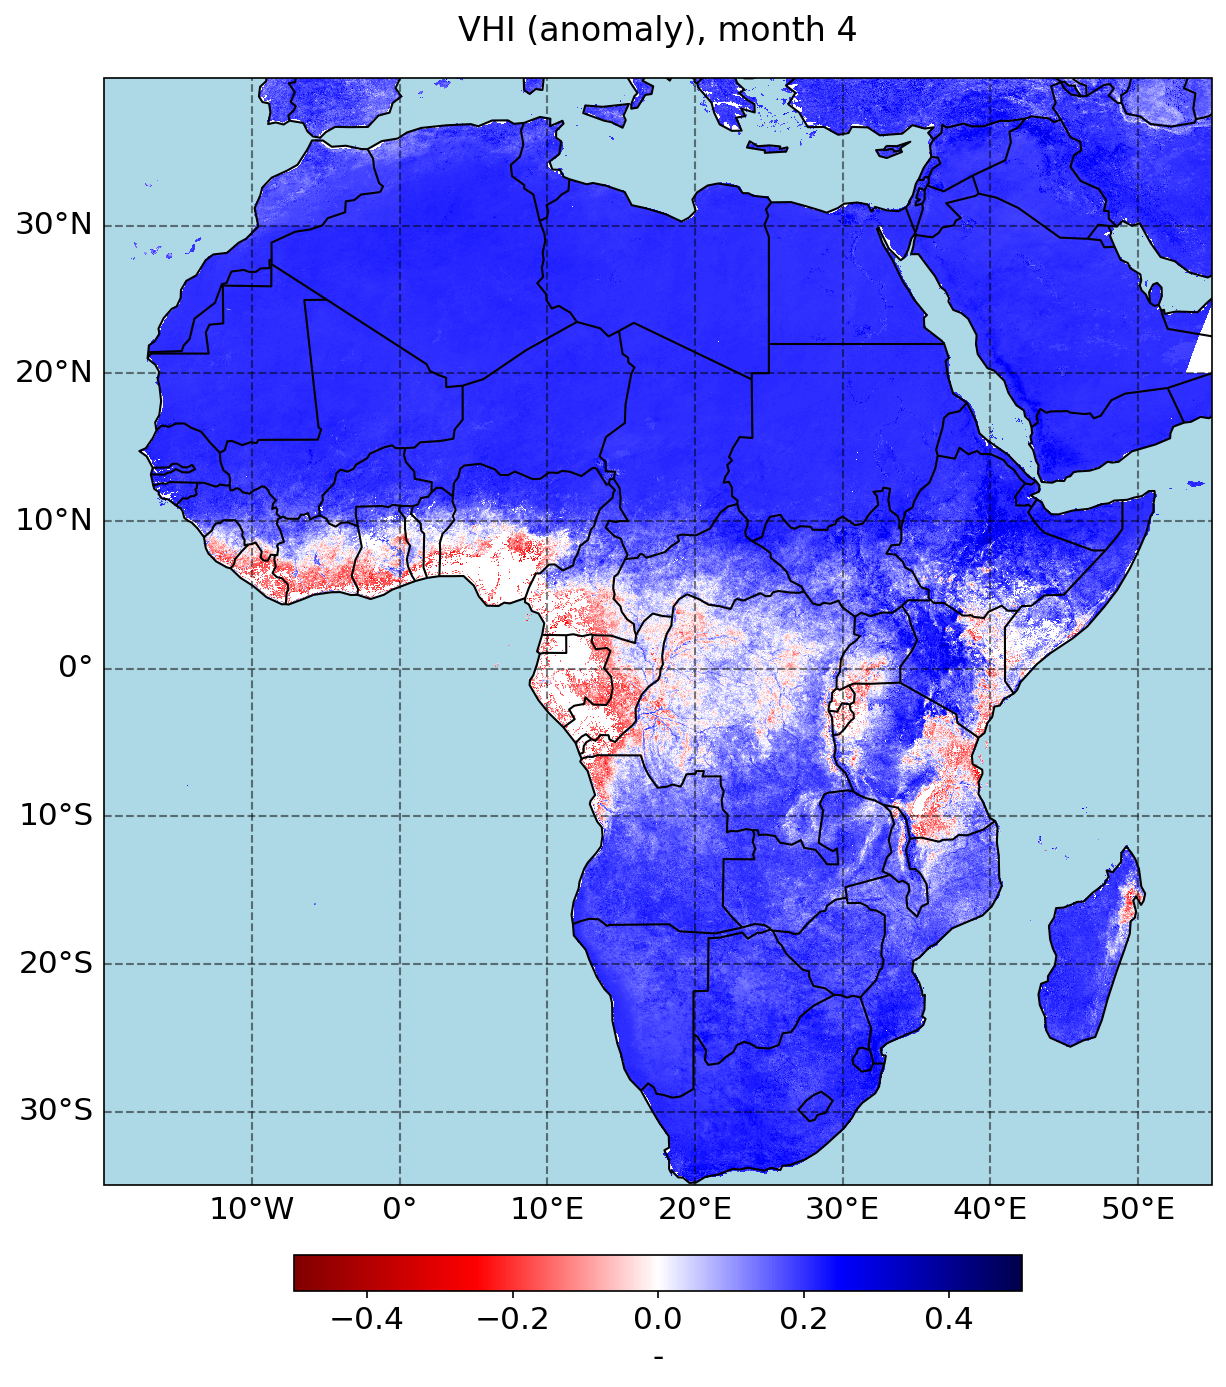

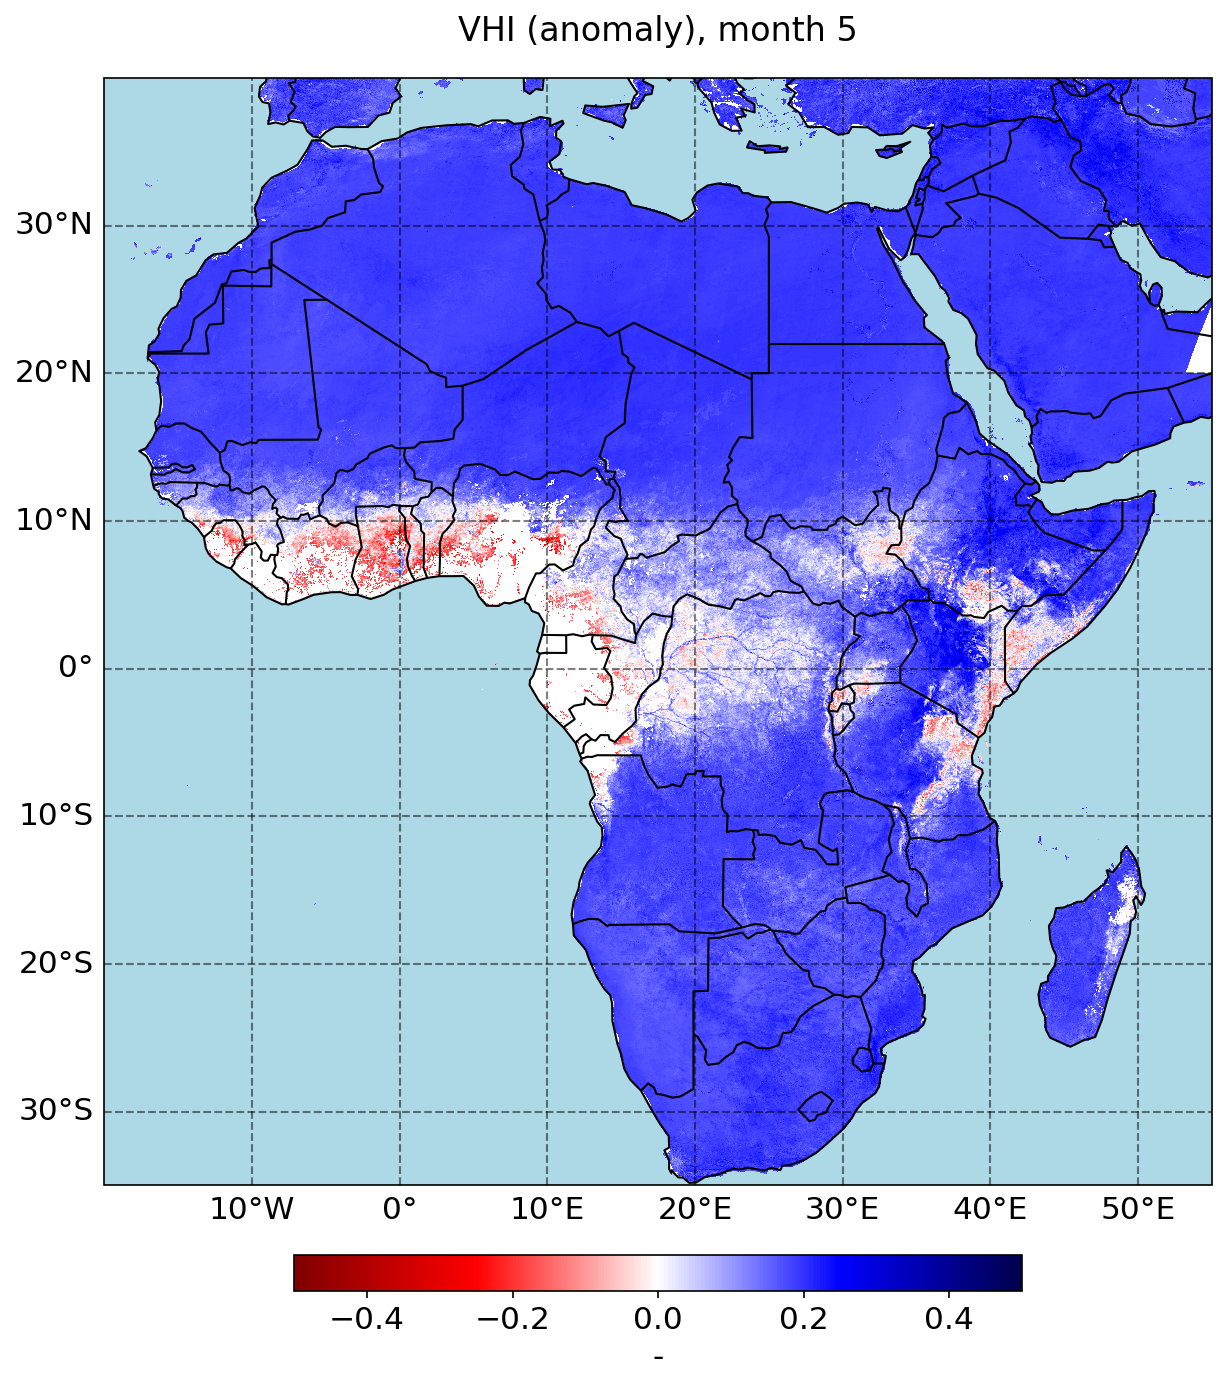

"\ntarget = NDVI_anomaly[:,:, month_index]\nhPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title=f'NDVI (anomaly), month {month_index + 3}', label_title='-', cmap='seismic_r', projection='PlateCarree')\n\ntarget = LST_anomaly[:,:, month_index]\nhPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title=f'LST (anomaly), month {month_index + 3}', label_title='-', cmap='seismic_r', projection='PlateCarree')\n"

In [38]:
month_index = 0 
target = VHI_anomaly[:,:, month_index]
hPlot.plot_map(domain_lon, domain_lat, target, -0.5, 0.5, plot_title=f'VHI (anomaly), month {month_index + 3}', label_title='-', cmap='seismic_r', projection='PlateCarree')

month_index = 1 
target = VHI_anomaly[:,:, month_index]
hPlot.plot_map(domain_lon, domain_lat, target, -0.5, 0.5, plot_title=f'VHI (anomaly), month {month_index + 3}', label_title='-', cmap='seismic_r', projection='PlateCarree')

month_index = 2 
target = VHI_anomaly[:,:, month_index]
hPlot.plot_map(domain_lon, domain_lat, target, -0.5, 0.5, plot_title=f'VHI (anomaly), month {month_index + 3}', label_title='-', cmap='seismic_r', projection='PlateCarree')

'''
target = NDVI_anomaly[:,:, month_index]
hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title=f'NDVI (anomaly), month {month_index + 3}', label_title='-', cmap='seismic_r', projection='PlateCarree')

target = LST_anomaly[:,:, month_index]
hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title=f'LST (anomaly), month {month_index + 3}', label_title='-', cmap='seismic_r', projection='PlateCarree')
'''

## 4. Read and plot resampled nc file 

In [25]:
#nc_file_name = f'{cpuserver_data_FP}/MODIS/MODIS_NDVI_LST_dates{len(NDVI_dates)}_R_eqd001.nc'
nc_file_name = f'/home/subin/MODIS_NDVI_LST_dates{len(NDVI_dates)}_R_eqd001.nc'

nc_data  = netCDF4.Dataset(nc_file_name)
NDVI_total  = nc_data.variables['NDVI'][:].data
LST_total  = nc_data.variables['LST'][:].data
domain_lon = nc_data.variables['longitude'][:].data
domain_lat = nc_data.variables['latitude'][:].data
nc_data.close()

In [ ]:
date_index = 0 # Maximum: len(NDVI_dates) - 1

target = NDVI_total[:,:, date_index]
hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title='NDVI (after resampling)', label_title='-', cmap='jet_r', projection='PlateCarree')

target = LST_total[:,:, date_index]
hPlot.plot_map(domain_lon, domain_lat, target, np.nanmin(target), np.nanmax(target), plot_title='LST (after resampling)', label_title='-', cmap='jet_r', projection='PlateCarree')

## 5. Time series analysis

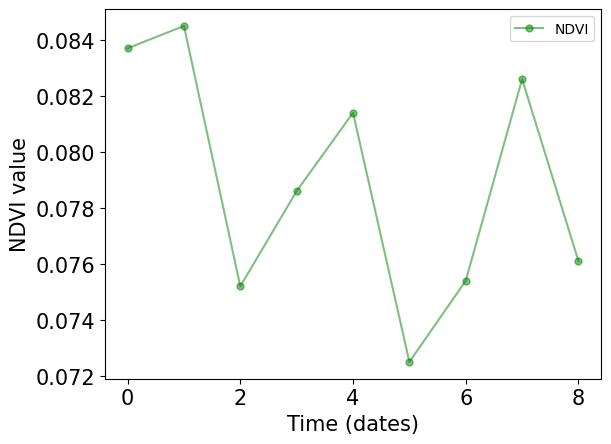

In [48]:
one_pixel = (1500, 1500)
one_lat, one_lon = one_pixel

one_NDVI = NDVI_total[one_lat, one_lon, :]

plt.plot(one_NDVI, marker='o', markersize=5, alpha=0.5, label='NDVI', color='green')
plt.xlabel('Time (dates)')
plt.ylabel('NDVI value')
plt.legend()
plt.show()

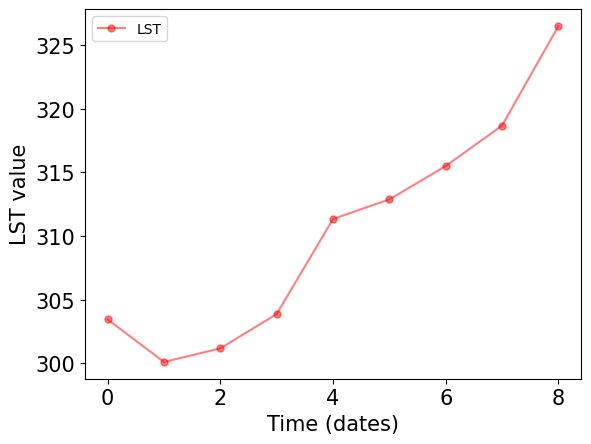

In [49]:
one_LST = LST_total[one_lat, one_lon, :]

plt.plot(one_LST, marker='o', markersize=5, alpha=0.5, label='LST', color='red')
plt.xlabel('Time (dates)')
plt.ylabel('LST value')
#plt.ylim([250, 350])
plt.legend()
plt.show()

In [50]:
mk.original_test(one_NDVI)

Mann_Kendall_Test(trend='no trend', h=False, p=0.46551216987418664, z=-0.7298004491997617, Tau=-0.2222222222222222, s=-8.0, var_s=92.0, slope=-0.0007375003769993782, intercept=0.0815499983727932)

In [51]:
mk.original_test(one_LST)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0012293849189448647, z=3.2319734178846593, Tau=0.8888888888888888, s=32.0, var_s=92.0, slope=3.1366628011067705, intercept=298.79334513346356)

## 6. Calculate VHI's MK slope for one point pixel

In [52]:
one_VCI = ( one_NDVI - np.nanmax(one_NDVI) ) / ( np.nanmax(one_NDVI) - np.nanmin(one_NDVI) )
one_TCI = ( np.nanmax(one_LST) - one_LST ) / ( np.nanmax(one_LST) - np.nanmin(one_LST) )

In [53]:
alpha = 0.5

one_VHI = alpha*one_VCI + (1-alpha)*one_TCI

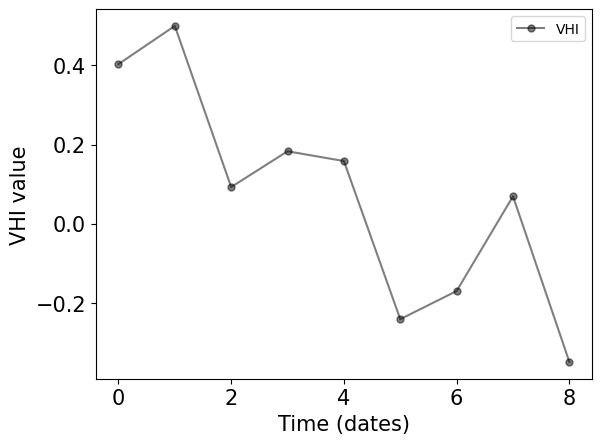

In [54]:
plt.plot(one_VHI, marker='o', markersize=5, alpha=0.5, label='VHI', color='black')
plt.xlabel('Time (dates)')
plt.ylabel('VHI value')
plt.legend()
plt.show()

<Axes: >

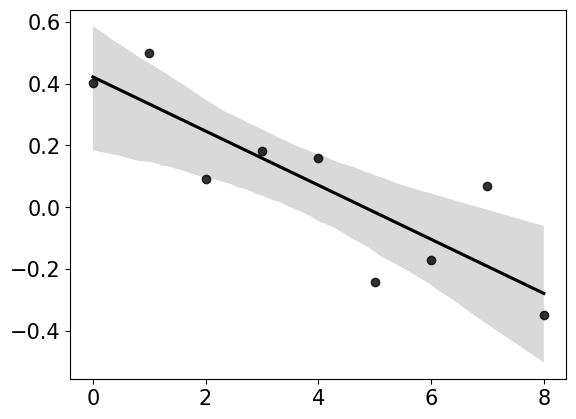

In [55]:
date_index_array = list(range(len(one_VHI)))
sns.regplot(x=date_index_array, y=one_VHI, color='black')

In [56]:
result = mk.original_test(one_VHI)
print(result.slope)
print('\n')
print(result)

-0.09191624820232391


Mann_Kendall_Test(trend='decreasing', h=True, p=0.01648865672767008, z=-2.39791576165636, Tau=-0.6666666666666666, s=-24.0, var_s=92.0, slope=-0.09191624820232391, intercept=0.4600740671157837)


## 7. Calculate VHI's MK slope for all pixels

In [57]:
def calculate_one_VHI_MK_slope(i, j, one_NDVI, one_LST, alpha):   
    try:
        one_VCI = ( one_NDVI - np.nanmax(one_NDVI) ) / ( np.nanmax(one_NDVI) - np.nanmin(one_NDVI) )
        one_TCI = ( np.nanmax(one_LST) - one_LST ) / ( np.nanmax(one_LST) - np.nanmin(one_LST) )
        one_VHI = alpha*one_VCI + (1-alpha)*one_TCI
        
        result = mk.original_test(one_VHI)
        slope = result.slope

    except ZeroDivisionError as e:
        slope = 0

    return slope

In [58]:
import multiprocessing as mp
import itertools

print(mp.cpu_count())

32


In [60]:
rows, cols = np.shape(NDVI_total[:, :, 0])
print(rows, cols)
#slope_total  = np.zeros((rows, cols),  dtype='float64')  

rows_list = range(rows)
cols_list = range(cols)
rows_cols_list = list(itertools.product(rows_list, cols_list))

alpha = 0.5

def parallel_func(row_col):
    i = row_col[0]
    j = row_col[1]
    one_NDVI = NDVI_total[i, j, :]
    one_LST = LST_total[i, j, :]
    slope = calculate_one_VHI_MK_slope(i, j, one_NDVI, one_LST, alpha)
    slope = round(slope, 8)
    slope *= 10e8
    #slope_total[i, j] = slope
    return int(slope)

pool = mp.Pool(20)
slope_total = pool.map(parallel_func, rows_cols_list)

7500 7500


In [61]:
slope_total = np.reshape(slope_total, (rows, cols))
np.save('/home/subin/MK_slope_total.npy', slope_total)

## 8. Read MK_slope_total.npy

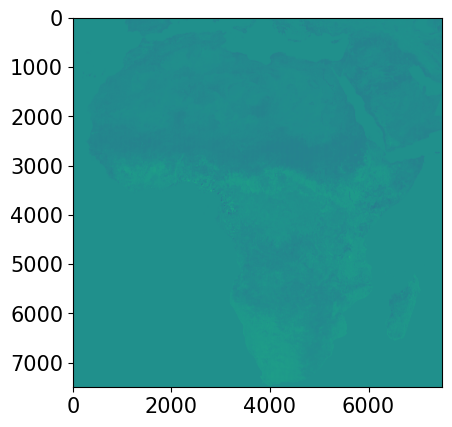

In [62]:
slope_total = np.load('/home/subin/MK_slope_total.npy')

plt.imshow(slope_total)

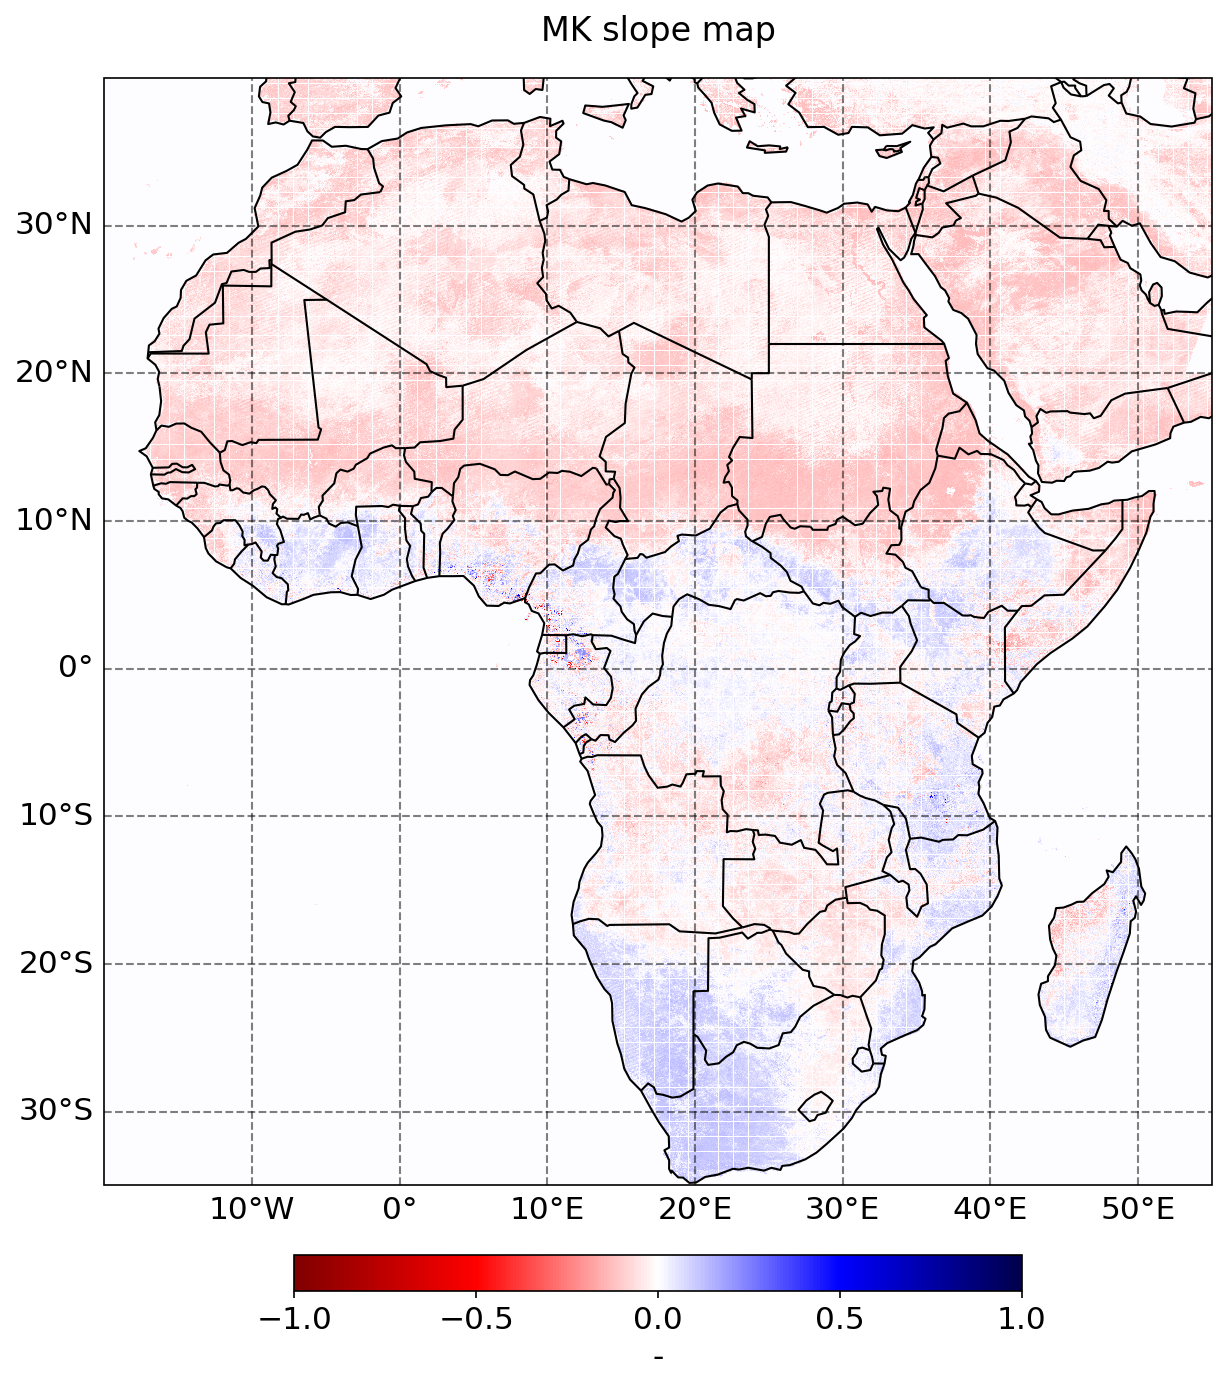

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [63]:
target = slope_total / 10e8
cmap_max = max(abs(np.nanmin(target)),np.nanmax(target))
cmap_min = -1 * cmap_max
                     
hPlot.plot_map(domain_lon, domain_lat, target, cmap_min, cmap_max, plot_title='MK slope map', label_title='-', cmap='seismic_r', projection='PlateCarree')

## 9. Compare MK slope Before & After Heat wave (2024)

In [65]:
NDVI_dates

['2024.01.01',
 '2024.01.17',
 '2024.02.02',
 '2024.02.18',
 '2024.03.05',
 '2024.03.21',
 '2024.04.06',
 '2024.04.22',
 '2024.05.08']

In [66]:
NDVI_total_before = NDVI_total[:, :, :5]
NDVI_total_after =  NDVI_total[:, :, 5:]

LST_total_before = LST_total[:, :, :5]
LST_total_after =  LST_total[:, :, 5:]

In [67]:
rows, cols = np.shape(NDVI_total[:, :, 0])
print(rows, cols)
#slope_total  = np.zeros((rows, cols),  dtype='float64')  

rows_list = range(rows)
cols_list = range(cols)
rows_cols_list = list(itertools.product(rows_list, cols_list))

alpha = 0.5


def parallel_func_before(row_col):
    i = row_col[0]
    j = row_col[1]
    one_NDVI = NDVI_total_before[i, j, :]
    one_LST = LST_total_before[i, j, :]
    slope = calculate_one_VHI_MK_slope(i, j, one_NDVI, one_LST, alpha)
    slope = round(slope, 8)
    slope *= 10e8
    #slope_total[i, j] = slope
    return int(slope)

pool = mp.Pool(20)
slope_total_before = pool.map(parallel_func_before, rows_cols_list)

7500 7500


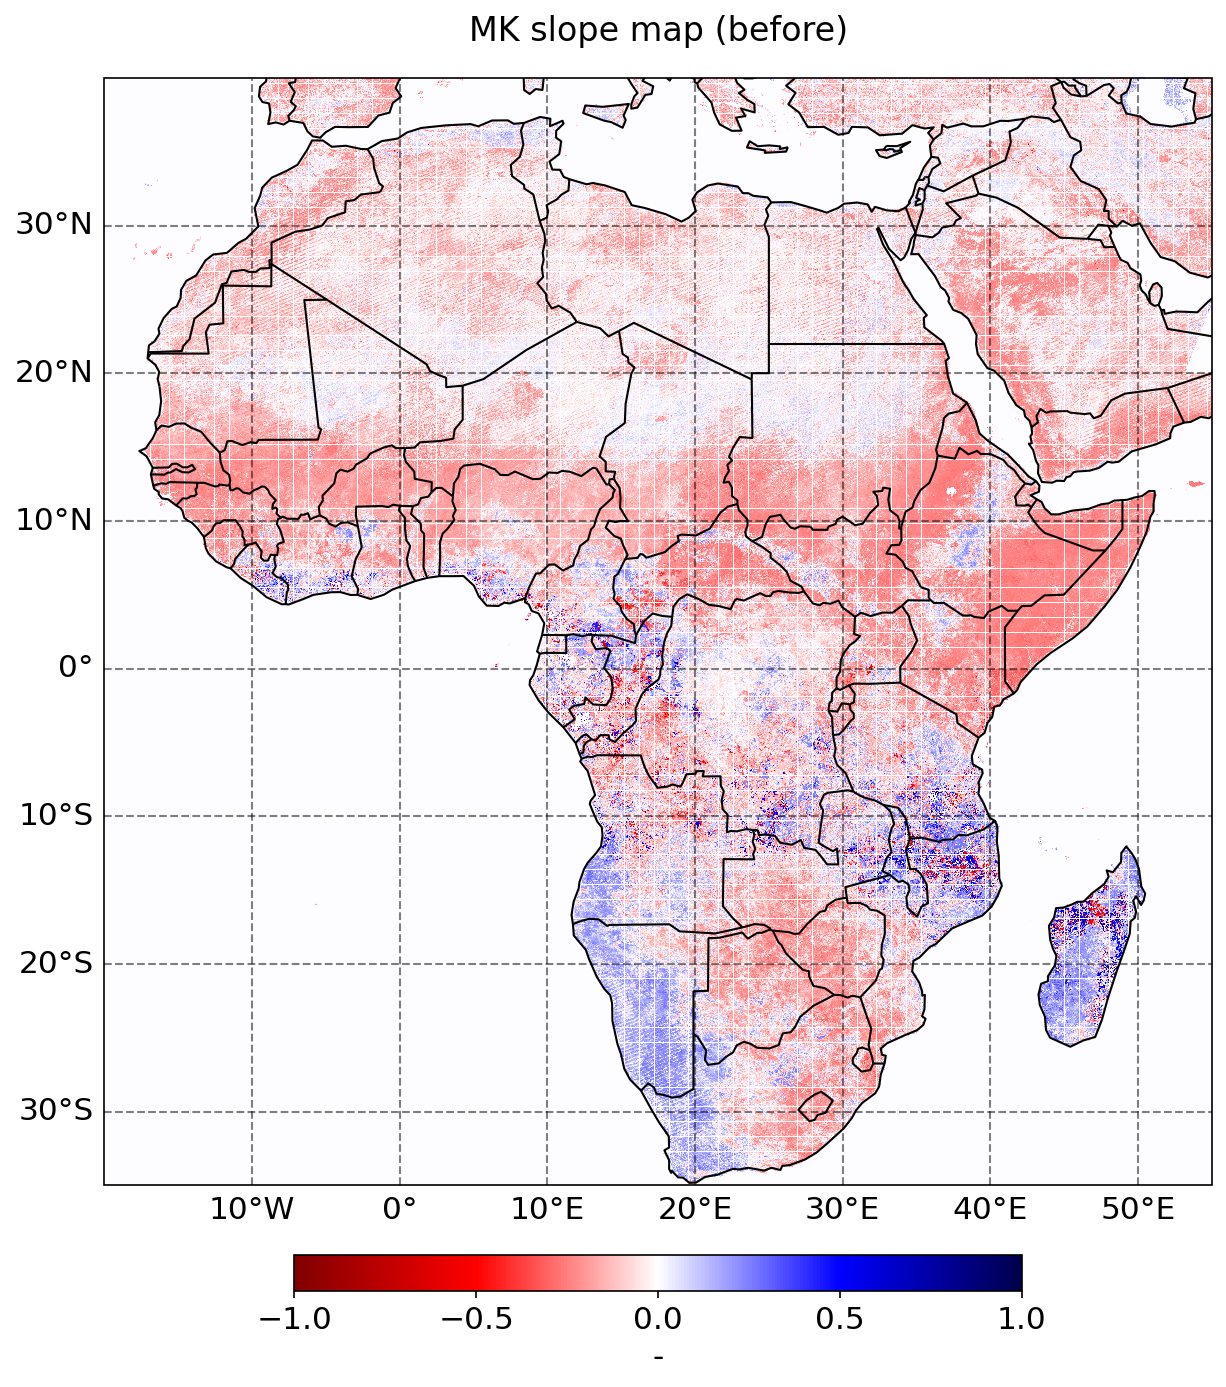

In [72]:
#slope_total_before = np.reshape(slope_total_before, (rows, cols))
#np.save('/home/subin/MK_slope_total_before.npy', slope_total_before)
slope_total_before = np.load('/home/subin/MK_slope_total.npy')

target = slope_total_before / 10e8
cmap_max = max(abs(np.nanmin(target)),np.nanmax(target))
cmap_min = -1 * cmap_max
                     
hPlot.plot_map(domain_lon, domain_lat, target, cmap_min, cmap_max, plot_title='MK slope map (before)', label_title='-', cmap='seismic_r', projection='PlateCarree')
slope_total_before = []

In [73]:
def parallel_func_after(row_col):
    i = row_col[0]
    j = row_col[1]
    one_NDVI = NDVI_total_after[i, j, :]
    one_LST = LST_total_after[i, j, :]
    slope = calculate_one_VHI_MK_slope(i, j, one_NDVI, one_LST, alpha)
    slope = round(slope, 8)
    slope *= 10e8
    #slope_total[i, j] = slope
    return int(slope)

pool = mp.Pool(20)
slope_total_after = pool.map(parallel_func_after, rows_cols_list)

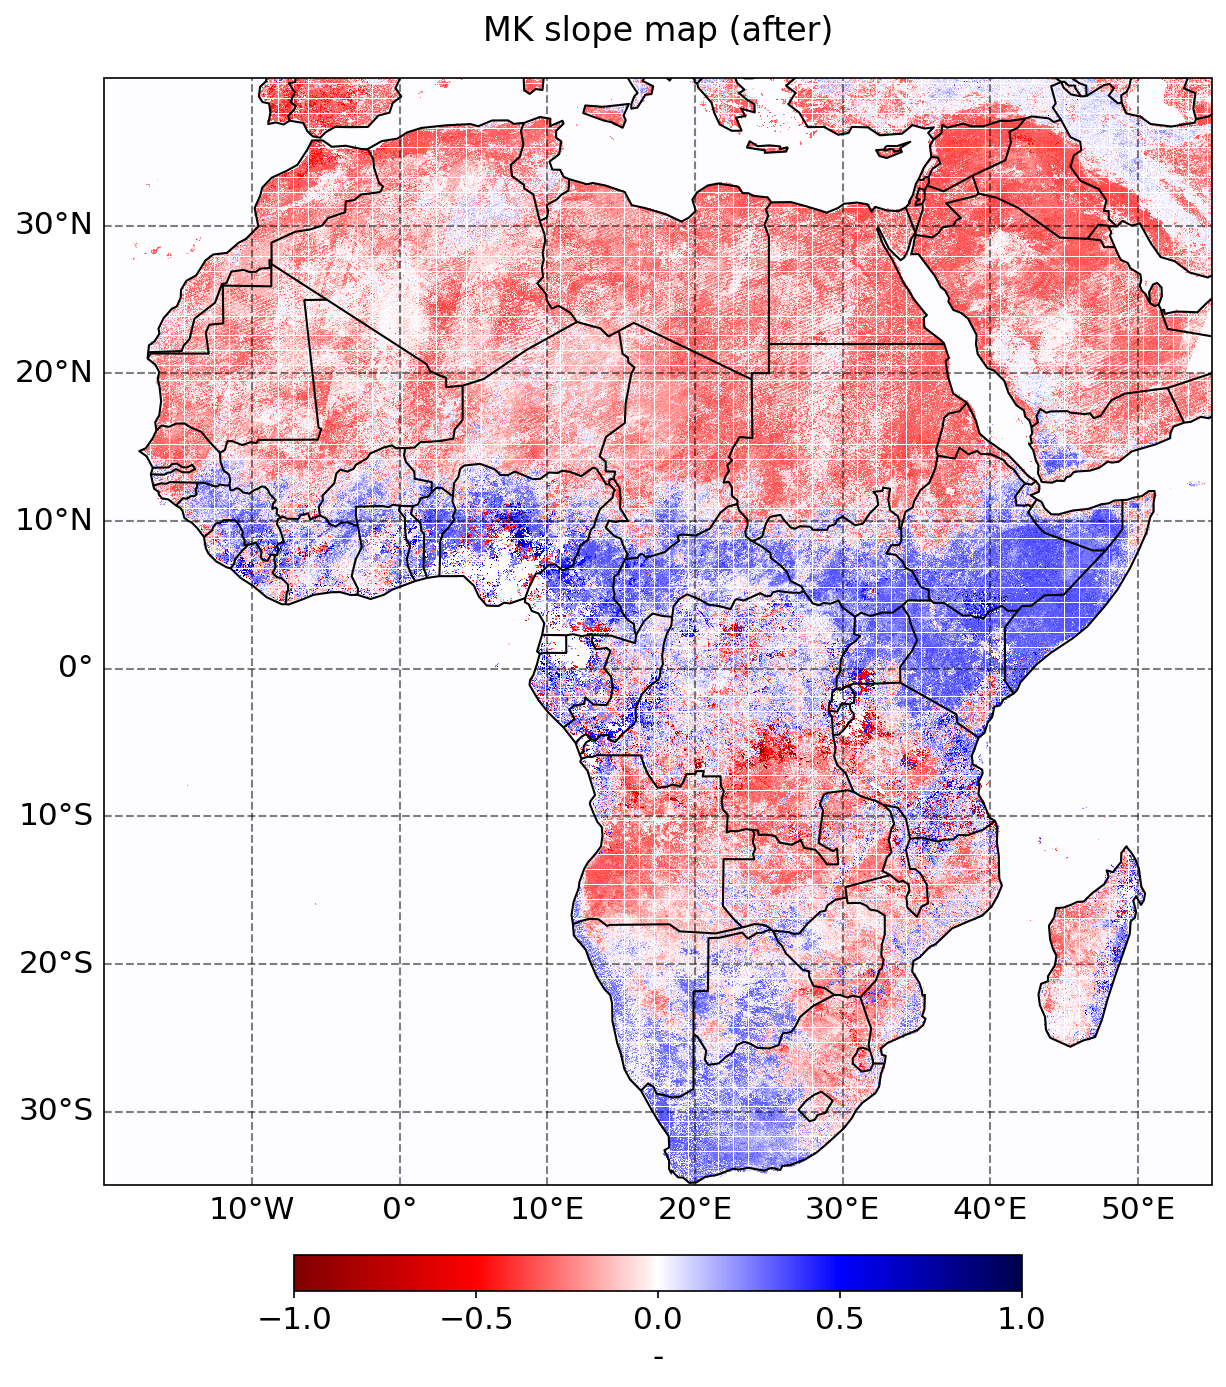

In [76]:
#slope_total_after = np.reshape(slope_total_after, (rows, cols))
#np.save('/home/subin/MK_slope_total_after.npy', slope_total_after)
slope_total_after = np.load('/home/subin/MK_slope_total_after.npy')

target = slope_total_after / 10e8
cmap_max = max(abs(np.nanmin(target)),np.nanmax(target))
cmap_min = -1 * cmap_max
                     
hPlot.plot_map(domain_lon, domain_lat, target, cmap_min, cmap_max, plot_title='MK slope map (after)', label_title='-', cmap='seismic_r', projection='PlateCarree')
slope_total_after = []